In [ ]:
# default_exp model.learner

In [ ]:
from IPython.core.debugger import set_trace
from IPython.utils import traitlets as _traitlets

/tmp/ipykernel_563168/2943078347.py:2: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


<h1><center> Learner </center></h1>

In this module, we define the model architecture that we will use in our learner. It will be based on [`tsai`](https://github.com/timeseriesAI/tsai) models with a simple tweak: ability to handle categorical features.

The strategy to build our model is fairly simple:
+ apply a specific 'Embedding` layer to each categorical feature
+ concatenate the outcome of the embedding layers with the continuous features
+ pass the resulting tensor to a `tsai` existing model
The first 2 steps can be handled by the *head* of the network which can be seen as a layer.

Once the architecture defined, we can define our learner in the usual way and benefit from `fastai` training loop.

In [ ]:
# export
import os
import pickle
import warnings
from random import sample
from typing import List, Tuple

import numpy as np
import pandas as pd
from fastai.layers import trunc_normal_
from fastai.tabular.all import *
from fastai.text.all import *
from fastai.vision.all import *
from fastcore.basics import *
from progressbar import progressbar
from tsai.models.RNN import *
from tsai.models.utils import *

from footSeq.datastruct.core import *

In [ ]:
data_path = Path("/sequences")
all_files = data_path.ls(file_exts='.csv')

In [ ]:
files = all_files[:40000]

In [ ]:
files_info = (
    pd.concat([parse_file_info(file) for file in progressbar(files)], axis=0)
    .convert_dtypes()
    .reset_index(drop=True)
)
labels = L(files_info.target.tolist()).unique(sort=True)

100% (40000 of 40000) |##################| Elapsed Time: 0:00:13 Time:  0:00:13


In order to test our different examples, let's prepare a batch of data:

In [ ]:
cat_names = [
    "standart_name",
    "possession_name",
    "attack_status_name",
    "attack_type_name",
    "under_pressure",
    "high_speed",
    "type_name",
    "result_name",
    "generic_action_type_name",
    "body_name",
    "is_poss_team",
    "is_att_team",
]
cont_names = [
    "start_x",
    "start_y",
    "end_x",
    "end_y",
    "time_seconds",
    "seconds_since_poss",
]

## splits
splits_files = goal_splitter(
    files_info_df=files_info, no_goal_prop=1.5, valid_pct=0.3, seed=43
)

procs = [FillMissing, Categorify, Normalize]
foot_tfm = FootSeqTransform(
    files=files,
    splits=splits_files,
    labels=labels,
    procs=procs,
    cat_names=cat_names,
    cont_names=cont_names,
)


## to-tensor transform
to_tsr = FootSeqToTensor(
    cat_names=cat_names,
    cont_names=cont_names,
    labels=labels,
    base_path=data_path,
    max_len=10,
)

## tfmdlist
tls = TfmdLists(files, [foot_tfm, to_tsr], splits=splits_files)

## params for datalodaers
train_seq_lens = L(min(get_sequence_len(file), 10) for file in files[splits_files[0]])
valid_seq_lens = L(min(get_sequence_len(file), 10) for file in files[splits_files[1]])


## pass the training dataset sequence lengths to SortedDL
srtd_dl = partial(SortedDL, res=train_seq_lens)

## Pass the validation dataset seq lengths
dl_kwargs = [{}, {"val_res": valid_seq_lens}]

## re-initialise dataloaders
srtd_dls = tls.dataloaders(
    bs=3, before_batch=pad_seq, dl_type=srtd_dl, dl_kwargs=dl_kwargs
)
srtd_batch = srtd_dls.one_batch()

srtd_batch

100% (1574 of 1574) |####################| Elapsed Time: 0:00:17 Time:  0:00:17


(tensor([[1171044,     139,   15559,   15571],
         [1171028,     168,  180420,  180452],
         [1171509,     215,   22292,   22310]], device='cuda:0'),
 tensor([[[ 5,  1,  1,  4,  1,  1,  7,  2, 12,  6,  2,  2],
          [ 5,  1,  1,  4,  1,  1, 20,  2,  8,  6,  2,  2],
          [ 5,  1,  1,  4,  1,  1,  7,  2, 12,  6,  2,  2],
          [ 5,  1,  1,  4,  1,  1, 11,  2,  3,  6,  2,  2],
          [ 5,  1,  1,  4,  1,  1,  7,  2, 12,  6,  2,  2],
          [ 5,  1,  1,  4,  1,  1, 11,  2,  3,  6,  2,  2],
          [ 5,  1,  1,  4,  1,  1,  7,  2, 12,  6,  2,  2],
          [ 5,  1,  1,  4,  1,  1, 11,  2,  3,  6,  2,  2],
          [ 5,  1,  1,  4,  1,  1,  7,  2, 12,  6,  2,  2],
          [ 5,  1,  1,  4,  1,  1, 11,  2,  3,  6,  2,  2]],
 
         [[ 5,  1,  1,  4,  1,  1, 11,  2,  3,  6,  2,  2],
          [ 5,  1,  1,  4,  1,  1, 38,  2, 13,  6,  2,  2],
          [ 5,  1,  1,  4,  1,  1, 18,  2, 12,  5,  2,  2],
          [ 5,  1,  2,  4,  1,  1,  7,  2, 12,  6,  2,  2

# Model

## Embedding

In [ ]:
# export


@delegates()
class Embedding(nn.Embedding):
    """
    Embedding layer compatible with full pytorch API and truncated normal initialization

    Parameters
    ----------
    ni, nf: int
        input and output size of Embedding layer. It is the same
        as `num_embeddings` and `embedding_dim` in `torch.nn.Embedding()` module
    kwargs: dict
        Any argument accepted by `torch.nn.Embedding()` module
        a part from `num_embeddings` and `embedding_dim`
    std: float
        standard deviation applied in the truncated normal

    """

    def __init__(self, ni, nf, std=0.01, **kwargs):
        kwargs["num_embeddings"], kwargs["embedding_dim"] = ni, nf
        super().__init__(**kwargs)
        trunc_normal_(self.weight.data.cuda(), std=std)


class MultiEmbedding(Module):
    """
    Muti-dimesnion Embedding layer

    Attributes
    ----------
    cat_embed: torch.nn.ModuleList
        list of Embedding modules in the order in which categorical data appear

    """

    def __init__(
        self,
        n_embeds: List[int],
        embed_dims: List[int] = None,
        embed_p: float = 0.0,
        n_cont: int = 0,
        std: float = 0.01,
        **kwargs
    ):
        """
        Initialise the various embedding sizes

        Parameters
        ----------
        n_embdes: List[int]
            length of the vocabulary of each categorical feature in the same order as passed in the tensor

        embed_dims: List[int]
            required size of each categorical feature embedding in the same order as passed in the tensor

        embed_p: float
            if non zero, applies a dropout layer to the the categorical features after embedding.

        n_cont: int, optional
            number of continuous features

        std: float
            standard deviation applied in the truncated normal
        kwargs: dict
            extra parameters passed to the embedding layer. Should be
            compatible with `torch.nn.Embedding()`

        """
        assert n_cont >= 0, "number of continuous features should be positive"
        self.n_cont = n_cont
        ## verify embedding size
        if embed_dims is None:
            embed_dims = [emb_sz_rule(s) for s in n_embeds]
        else:
            embed_dims = listify(embed_dims)
            if len(embed_dims) == 1:
                embed_dims = embed_dims * len(n_embeds)
            assert len(embed_dims) == len(n_embeds)

        self.emb_drop = nn.Dropout(embed_p)
        self.cat_embed = nn.ModuleList(
            [
                Embedding(ni=n, nf=d, std=std, **kwargs)
                for n, d in zip(n_embeds, embed_dims)
            ]
        )

    def forward(self, x_cat, x_cont=None):
        x_cat = torch.cat([e(x_cat[..., i]) for i, e in enumerate(self.cat_embed)], -1)
        x_cat = self.emb_drop(x_cat)
        if self.n_cont != 0:
            x_cat = torch.cat([x_cat, x_cont], -1)
        return x_cat

In order to test this layer, we need to find the vocabulary size of each categorical variable and pass it in `n_embeds`:

In [ ]:
n_embeds = [len(tls.to.classes[n]) for n in tls.to.cat_names]
(tls.to.cat_names, n_embeds)

((#12) ['standart_name','possession_name','attack_status_name','attack_type_name','under_pressure','high_speed','type_name','result_name','generic_action_type_name','body_name'...],
 [7, 6, 5, 7, 3, 3, 52, 3, 15, 7, 3, 3])

Now let's initialize the layer and check that it works as expected:

In [ ]:
n_cont = srtd_batch[2].shape[-1]
multi_em = MultiEmbedding(n_embeds=n_embeds, n_cont=n_cont).cuda()
tsr_em = multi_em(srtd_batch[1], srtd_batch[2])
test_eq(
    tsr_em.shape[-1],
    L(w.weight.shape[-1] for w in multi_em.cat_embed).sum() + n_cont,
)

Now let's investigate how we can use the `padding_idx` option. This can be very useful to avoid training useless weight corresponding to padding values. Let's first create a batch with some padded values:

In [ ]:
reg_dls = tls.dataloaders(bs=5, before_batch=pad_seq)
padded_batch = reg_dls.one_batch()
padded_batch[1][1]

tensor([[ 5,  1,  2,  4,  1,  1,  5,  2,  4,  6,  1,  1],
        [ 5,  1,  1,  4,  1,  1,  7,  2, 12,  6,  2,  2],
        [ 5,  1,  4,  4,  1,  1, 20,  2,  8,  6,  2,  2],
        [ 5,  1,  1,  4,  1,  1,  7,  2, 12,  6,  2,  2],
        [ 5,  1,  1,  4,  1,  1, 11,  2,  3,  6,  2,  2],
        [ 5,  1,  1,  4,  1,  1,  7,  2, 12,  6,  2,  2],
        [ 5,  1,  1,  4,  1,  1, 38,  2, 13,  6,  2,  2],
        [ 5,  1,  1,  4,  1,  1,  8,  1, 12,  5,  2,  2],
        [ 5,  1,  1,  4,  1,  1, 16,  1,  6,  5,  2,  2],
        [ 5,  1,  1,  4,  1,  1, 36,  2, 11,  6,  1,  1]], device='cuda:0')

In [ ]:
multi_em_pad = MultiEmbedding(n_embeds, padding_idx=0, n_cont=n_cont).cuda()
tsr_em = multi_em_pad(padded_batch[1], padded_batch[2])
tsr_em[0]

tensor([[-1.5715,  0.4795, -0.3564,  0.4124, -1.1652,  0.1304,  0.1424, -0.1794,
          0.8194,  0.9754,  1.1234, -1.1654,  0.9167,  0.5023, -1.1093, -1.1730,
          0.6737, -0.2305, -0.7794, -0.7978,  2.1199, -0.8496, -1.6397, -0.1309,
          1.0407,  0.4823,  2.4591,  1.0301,  0.9131,  0.4411, -1.1272,  0.2788,
         -1.2713,  1.3729, -0.9573,  0.2320,  1.6109,  0.9727,  0.5163,  0.8994,
          0.2716, -1.0667,  0.6925,  0.4644, -0.0042,  0.7912, -0.0750,  0.6443,
         -0.2776, -0.3275,  0.0073, -0.5480, -0.1737,  1.1220, -0.4359,  0.8072,
          0.3954, -0.9147,  0.4663, -0.5573, -0.0570,  0.7952, -0.0624,  1.4325,
         -0.6444, -0.9214],
        [-0.6324,  0.6574,  0.4839,  0.2629, -0.0539,  0.6979,  0.0375,  0.5712,
         -1.5517, -0.1964, -0.2928, -0.3015,  0.2310,  0.5023, -1.1093, -1.1730,
          0.6737, -0.2305, -0.7794, -0.7978,  2.1199, -0.8496, -1.6397, -0.1309,
          1.0343, -0.0721, -0.1047,  0.4589,  1.4578,  0.4511, -0.2898, -0.7590,


Notice how the dimension with all zeros (the default padding index) are also filled in with all zeros in the resulting tensor.

## Full Architecture

Now we are ready to plug in the embedding to any `tsai` learner. Our architecture is fairly straightforward:
+ `head` is the head of the network and runs the data through the `multiEmbedding` layer
+ `body` takes the output of `head` and run it through the desired architecture selected by the user in `ts_arch`

In [ ]:
# export


@delegates(build_ts_model)
class MixedSeqModel(Module):
    "Sequence model with an embedding head."

    def __init__(
        self,
        arch: Module,
        n_cont: int,
        c_out: int,
        embded_config: dict = None,
        **kwargs
    ):
        """
        Intialise the model architecture

        Parameters
        ----------
        arch: Module
            one of tsai Model architectures accepted by `build_ts_model()`
        c_out: int
            number of output layers
        n_cont: int
            number of continuous features
        embed_config: dict
            all parameters accepted by the `MultiEmbedding` layer
        kwargs:
            Extra parameters accepted by `build_ts_model()`

        """
        ## head of the network
        embded_config["n_cont"] = n_cont
        self.head = MultiEmbedding(**embded_config)

        ## inialise the body
        self.arch, self.c_out, self.n_cont = arch, c_out, n_cont
        self.c_in = L(w.weight.shape[-1] for w in self.head.cat_embed).sum() + n_cont
        kwargs["arch"], kwargs["c_in"], kwargs["c_out"] = (
            self.arch,
            self.c_in,
            self.c_out,
        )

        self.body = build_ts_model(**kwargs)

    def forward(self, x_meta, x_cat, x_cont):
        ## run through head first
        x = self.head(x_cat, x_cont)

        return self.body(x.transpose(2, 1))

In [ ]:
from tsai.models.RNN_FCN import *

n_cont = padded_batch[2].shape[-1]

## select the architecture
ts_model = LSTM_FCN
ts_args = {"bidirectional": True, "rnn_layers": 2, "shuffle": False}

## LSTM
##ts_model = LSTM
##ts_args = {"n_layers":2, "bidirectional":True}

model = MixedSeqModel(
    arch=ts_model,
    n_cont=n_cont,
    c_out=2,
    embded_config={"n_embeds": n_embeds, "embed_p": 0.1},
    **ts_args
).cuda()
model

MixedSeqModel(
  (head): MultiEmbedding(
    (emb_drop): Dropout(p=0.1, inplace=False)
    (cat_embed): ModuleList(
      (0): Embedding(7, 5)
      (1): Embedding(6, 4)
      (2): Embedding(5, 4)
      (3): Embedding(7, 5)
      (4): Embedding(3, 3)
      (5): Embedding(3, 3)
      (6): Embedding(52, 15)
      (7): Embedding(3, 3)
      (8): Embedding(15, 7)
      (9): Embedding(7, 5)
      (10): Embedding(3, 3)
      (11): Embedding(3, 3)
    )
  )
  (body): LSTM_FCN(
    (rnn): LSTM(66, 100, num_layers=2, batch_first=True, bidirectional=True)
    (rnn_dropout): Dropout(p=0.8, inplace=False)
    (shuffle): Permute(dims=0, 2, 1)
    (convblock1): ConvBlock(
      (0): Conv1d(66, 128, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock2): ConvBlock(
      (0): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (1): BatchNor

In [ ]:
model(padded_batch[0], padded_batch[1], padded_batch[2])

tensor([[-0.0676, -0.2600],
        [-0.2249, -0.2736],
        [-0.1876, -0.3865],
        [-0.1055, -0.1998],
        [-0.3873, -0.3907]], device='cuda:0', grad_fn=<AddmmBackward>)

# Learner

Defining a learner at this stage is straightforward, we just need to decide on the appropriate loss function to use, pass the `dataloaders` and the metrics we want to track. Moreover, the `tsai` `ts_learner` function provides a great interface that we could extend to meet our purposes: 

## Specific class for the `Learner`
We define a specific class `MixedSeqLearner` that knows how to predict the sequence and how to show results:

In [ ]:
# export


class MixedSeqLearner(Learner):
    "`Learner` for mixed sequence data"

    def predict(self, files: List[Path]):
        "Predict a sequence of play read from a file"
        dl = self.dls.test_dl(listify(files))
        preds, _, cls_preds = self.get_preds(
            dl=dl, with_decoded=True
        )
        labels = dl.tfms.target_vocab[0]
        probs = pd.DataFrame(preds.detach().numpy(), columns=labels)
        clss = [labels[i] for i in cls_preds]
        
        return probs, clss


@delegates(build_ts_model)
def mixed_seq_learner(
    arch: Module,
    n_cont: int,
    c_out: int,
    embded_config: dict = None,
    # learner args
    dls=None,
    splitter=trainable_params,
    loss_func=None,
    opt_func=Adam,
    lr=defaults.lr,
    cbs=None,
    metrics=None,
    path=None,
    model_dir="models",
    wd=None,
    wd_bn_bias=False,
    train_bn=True,
    moms=(0.95, 0.85, 0.95),
    # other model args
    **kwargs
):
    """
    Interface to create a `Learner` for sequences with continuous and categorical features

    Parameters
    ----------
    arch: Module
        one of tsai Model architectures accepted by `build_ts_model()`
    c_out: int
        number of output layers
    n_cont: int
        number of continuous features
    embed_config: dict
        all parameters accepted by the `MultiEmbedding` layer

    Returns
    -------
    fastai.Learner
        Learner object with the `MixedSeqModel` model architecture

    """
    if arch is None:
        arch = LSTM

    model = MixedSeqModel(
        arch=arch, n_cont=n_cont, c_out=c_out, embded_config=embded_config, **kwargs
    )
    try:
        model.body[0], model.body[1]
        subscriptable = True
    except:
        subscriptable = False
    if subscriptable:
        splitter = ts_splitter
    if loss_func is None:
        if hasattr(dls, "loss_func"):
            loss_func = dls.loss_func
        elif hasattr(dls, "train_ds") and hasattr(dls.train_ds, "loss_func"):
            loss_func = dls.train_ds.loss_func
        elif hasattr(dls, "cat") and not dls.cat:
            loss_func = MSELossFlat()

    learn = MixedSeqLearner(
        dls=dls,
        model=model,
        loss_func=loss_func,
        opt_func=opt_func,
        lr=lr,
        cbs=cbs,
        metrics=metrics,
        path=path,
        splitter=splitter,
        model_dir=model_dir,
        wd=wd,
        wd_bn_bias=wd_bn_bias,
        train_bn=train_bn,
        moms=moms,
    )

    # keep track of args for loggers
    store_attr("arch", self=learn)

    return learn

Let's define a learner now with the `LSTM_FCN` architecture and find an appropriate learning rate:

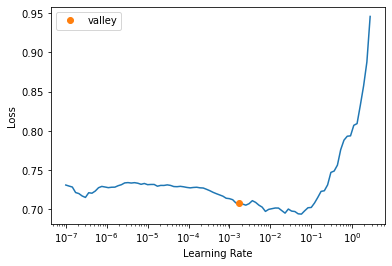

In [ ]:
from fastai.metrics import *

n_cont = padded_batch[2].shape[-1]

## prepare dataloaders
srtd_dls = tls.dataloaders(
    bs=64, before_batch=pad_seq, dl_type=srtd_dl, dl_kwargs=dl_kwargs
)

## select the architecture
ts_model = LSTM_FCN
ts_args = {"bidirectional": True, "rnn_layers": 2, "shuffle": False}
learn = mixed_seq_learner(
    arch=ts_model,
    n_cont=n_cont,
    c_out=2,
    embded_config={"n_embeds": n_embeds, "embed_p": 0.1},
    dls=srtd_dls,
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy],
    **ts_args
)
lr_ = learn.lr_find()

We can train the learner for 2 cycles:

In [ ]:
learn.fit_one_cycle(2, 0.9 * lr_[0])

epoch,train_loss,valid_loss,accuracy,time
0,0.664083,0.457987,0.876310,00:07
1,0.621558,0.452707,0.844864,00:06


We can now compute some predictions on some files. We will select `n_ex` sequences ending with a goal and the same number ending in no-goal:

In [ ]:
n_ex = 3 

## goal files
goal_idx = np.where(files_info.target == "goal")[0]; np.random.shuffle(goal_idx)
no_goal_idx = np.where(files_info.target != "goal")[0]; np.random.shuffle(no_goal_idx)

test_files = files[goal_idx[:n_ex].tolist() + no_goal_idx[:n_ex].tolist()]

In [ ]:
learn.predict(test_files)

(       goal   no-goal
 0  0.605787  0.394213
 1  0.818376  0.181624
 2  0.306486  0.693514
 3  0.114416  0.885584
 4  0.288987  0.711013
 5  0.197915  0.802086,
 ['goal', 'goal', 'no-goal', 'no-goal', 'no-goal', 'no-goal'])

Looking at raw numbers is fine but it is better to visualize the actions on a pitch. In order to do that, we provide a proper `show_results()` method that knows how to display the sequence together with the predictions:

In [ ]:
@typedispatch
def show_results(
    x: tuple,
    y,
    samples,
    outs,
    ctxs=None,
    max_n=6,
    nrows=None,
    ncols=1,
    figsize=None,
    **kwargs,
):
    n_elems = len(samples)
    if max_n > n_elems:
        max_n = n_elems
    if figsize is None:
        figsize = (10, 10 * 2.7)
    if ctxs is None:
        fig, ctxs = get_grid(
            max_n, nrows=None, ncols=ncols, figsize=figsize, return_fig=True
        )
    
    ## collect learner if available
    if "learner" in kwargs:
        learn = kwargs["learner"]
        labels = learn.dls.tfms.target_vocab[0]
        probs, _, pred_cls = learn.get_preds(dl = [x], with_decoded=True)
        probs = pd.DataFrame(probs.detach().numpy(), columns=labels)
        for i, ctx in enumerate(ctxs):
            pred_class = labels[pred_cls[i].item()]
            proba = probs[pred_class].values[i]
            title = (
                f'Actual: {samples[i][1]} \n Prediction: {pred_class} ({proba:.3f})'
            )
            samples[i].show(ctx=ctx, fig=fig, title=title)
    else:
        for i, ctx in enumerate(ctxs):
            title = (
                f'Actual: {samples[i][1]} \n Prediction: {["goal","no_goal"][y[i].item()]}'
            )
            samples[i].show(ctx=ctx, fig=fig, title=title)

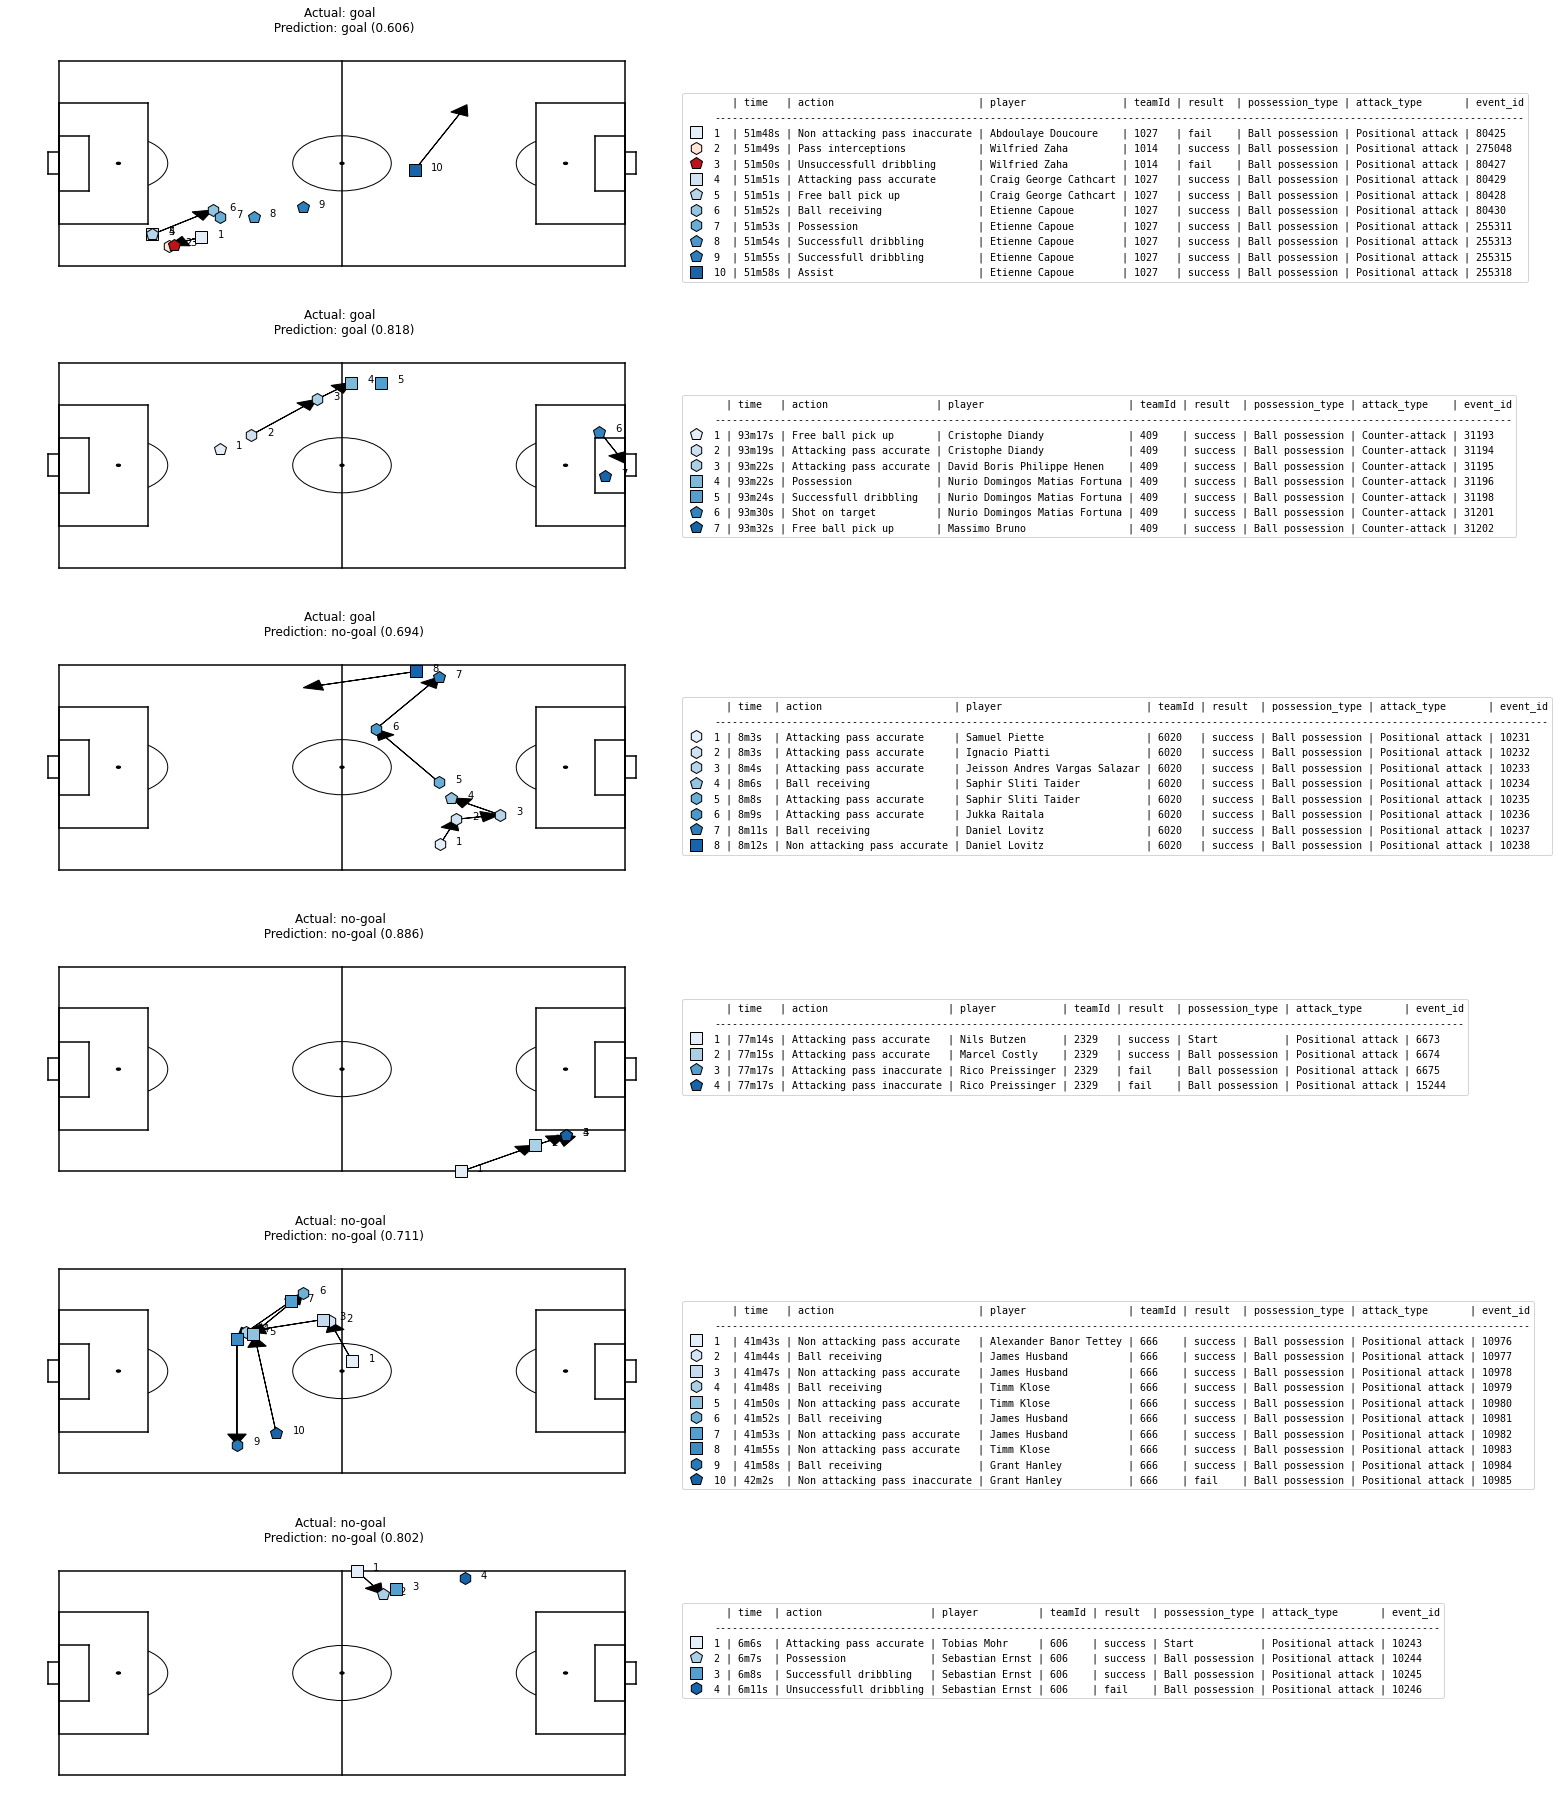

In [ ]:
base_fig_size = 12

test_dl = learn.dls.test_dl(test_files)
learn.show_results(dl = test_dl, figsize=(base_fig_size, base_fig_size * 2.7), max_n=6, ncols=1, learner=learn)